<a href="https://colab.research.google.com/github/shaked571/RL_Project/blob/master/Q_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!sudo apt-get update
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1
!pip install tqdm
import gym
from gym.wrappers import Monitor
import glob
import io
import base64
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
from tqdm import tqdm

Hit:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:2 http://security.ubuntu.com/ubuntu bionic-security InRelease
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:7 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:9 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:10 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:13 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic 

In [2]:
display = Display(visible=0, size=(1400, 900))
display.start()

"""
Utility functions to enable video recording of gym environment 
and displaying it.
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [3]:
# This code creates a virtual display to draw game images on. 
# If you are running locally, just ignore it
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

In [4]:
!apt-get install x11-utils > /dev/null 2>&1 
!pip install pyglet > /dev/null 2>&1 
!apt-get install -y xvfb python-opengl > /dev/null 2>&1
import gym
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
!pip install Box2d

In [5]:
import gym
import numpy as np
import random
import math
from collections import defaultdict, deque
import matplotlib.pyplot as plt
import glob
import io
from gym.wrappers import Monitor
from IPython.display import HTML
from pyvirtualdisplay import Display
from IPython import display as ipythondisplay
import base64

In [9]:
gym.logger.set_level(40)

bucket_size_states = (4,5,5,5,4,5,4,5,2,4,5,4,5,2)
dim_states = len(bucket_size_states)

bucket_size_action = (20,20,20,20)
dim_action = len(bucket_size_action)
sBounds = [(0, math.pi),
           (-2,2),
           (-1,1),
           (-1,1),
           (0,math.pi),
           (-2,2),
           (0, math.pi),
           (-2,2),
           (0,1),
           (0, math.pi),
           (-2, 2),
           (0, math.pi),
           (-2, 2),
           (0, 1)]
aBounds = (-1, 1)

env = gym.make('BipedalWalker-v3')
env = wrap_env(env)


def update_Q(lear_rate, disc_rate, q_table, state, action, reward, next_state=None):
    """Returns updated Q-value for the most recent experience."""
    current = q_table[state][action]  # estimate in Q-table (for current state, action pair)
    # get value of state, action pair at next time step
    Qsa_next = np.max(q_table[next_state]) if next_state is not None else 0
    target = reward + (disc_rate * Qsa_next)               # construct TD target
    new_value = current + (lear_rate * (target - current)) # get updated value
    return new_value


def state_to_bucket(state):
    bucket_state = []
    for i in range(len(state)):
        bucket_index = int((state[i]-sBounds[i][0])
                           / (sBounds[i][1]-sBounds[i][0])*bucket_size_states[i]-1)
        bucket_state.append(bucket_index)
    return tuple(bucket_state)


def bucket_to_action(bucket_action):
    action = []
    for i in range(len(bucket_action)):
        value_action = bucket_action[i] \
                       / (bucket_size_action[i] -1 ) * (aBounds[1] - aBounds[0]) - 1
        action.append(value_action)
    return tuple(action)


def choose_action(q_table, state, eps):
    # Select a random action
    if random.random() < eps:
        #print("azione random")
        action = ()
        for i in range (0, dim_action):
            action += (random.randint(0, bucket_size_action[i]-1),)
        #action = action_to_bucket(env.action_space.sample())
    # Select the action with the highest q
    else:

        action = np.unravel_index(np.argmax(q_table[state]), q_table[state].shape)
        #print("azione max q_table", action, "q-value", q_table[state][action])
    return action


def dd():
    return np.zeros(bucket_size_action)


def q_learning(env, num_episodes=100000, learn_rate= 0.01, disc_rate = 0.99, plot_every=1000):
    fig= plt.figure()
    xdata, ydata = [],[]
    ax=fig.add_subplot()
    plt.xlabel('Episode Number')
    plt.ylabel('Average Reward (Over Next %d Episodes)' % plot_every)
    Ln, = ax.plot(xdata,ydata)
    ax.set_xlim([plot_every,num_episodes])
    ax.set_ylim([-100,300])


    #q_table = np.zeros(bucket_size_states + bucket_size_action)
    #q_table = defaultdict(lambda: np.zeros(bucket_size_action))
    q_table = defaultdict(dd)
    #monitor performance
    tmp_scores = deque(maxlen=plot_every)  # deque for keeping track of scores
    avg_scores = deque(maxlen=num_episodes)  # average scores over every plot_every episodes

    for i_episode in tqdm(range(1, num_episodes + 1)):
        state = state_to_bucket(env.reset()[0:dim_states])
        total_reward = 0
        eps = 1.0/i_episode
        while True:
            #env.render()
            action = choose_action(q_table, state, eps)
            action_real = bucket_to_action(action)
            next_state_real, reward, done, info = env.step(action_real)
            next_state = state_to_bucket(next_state_real[0:dim_states])
            total_reward += reward
            q_table[state][action] = update_Q(learn_rate, disc_rate, q_table, state, action, reward, next_state)
            state = next_state
            if done:
                tmp_scores.append(total_reward)
                break

        if (i_episode % plot_every == 0):
            # plot performance
            print(f"total_reward: {total_reward}")
            print(f"next_state_real: {next_state_real}")
            print(f"done: {done}")
            print(f"info: {info}")
            print("salvo performance")
            xdata.append(i_episode)
            ydata.append(np.mean(tmp_scores))
            Ln.set_ydata(ydata)
            Ln.set_xdata(xdata)
            # fig.show()
            # fig.savefig(f"/content/drive/My Drive/pic_{i_episode}.png")
            # fig.savefig(f"img_output/pic_{i_episode}")
            # print best 100-episode performance
            # print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
            # f = open("/content/drive/My Drive/Colab Notebooks/q_table_learning_3.pkl", "wb")
            # pickle.dump(q_table,f)
            # f.close()
        # print("num_episodio", i_episode)

    env.close()

    # plot performance

    # print best 100-episode performance
    # print(('Best Average Reward over %d Episodes: ' % plot_every), np.max(avg_scores))
    return q_table



# New Section

total_reward: -106.72137337622485
next_state_real: [-0.45156872  0.02844154  0.07667275 -0.05243396 -0.82927102 -0.62046272
 -0.62131894  0.          0.         -0.84075123 -0.52697825 -0.05979002
 -1.00000032  0.          0.14041476  0.14200938  0.14697938  0.15593894
  0.17013049  0.19190501  0.22588885  0.28220043  0.38750312  0.64114368]
done: True
info: {}
salvo performance
total_reward: -108.84391761844316
next_state_real: [-0.51823014  0.01017307  0.06071146 -0.0176906  -0.87553716 -0.72910738
 -0.615201    0.          0.         -0.86814082 -0.72910738  0.45691907
  1.00000008  0.          0.15147968  0.15319996  0.15856159  0.16822718
  0.18353705  0.20702745  0.24368925  0.30443829  0.41803899  0.69166684]
done: True
info: {}
salvo performance
total_reward: -103.98944566689521
next_state_real: [-4.49792355e-01  1.51424253e-02  8.61259818e-02 -2.78580165e-02
 -8.29538763e-01  2.23517418e-08 -6.14294767e-01  0.00000000e+00
  0.00000000e+00 -8.34906876e-01  0.00000000e+00 -3.673

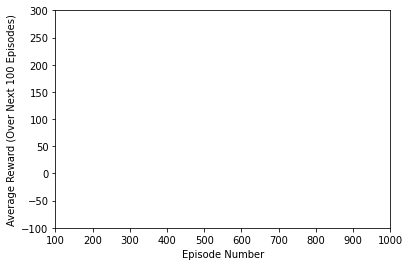

In [10]:
Q_learn = q_learning(env, num_episodes=3000, plot_every=100)
show_video()

In [11]:
from tqdm import tqdm